In [251]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit, expit


def rescale_beta(x, lower=-3, upper=3):
    res = (x - lower) / (upper - lower)
    return((res * (len(x) - 1) + .5) / len(x))


def standardize(x):
    return( (x - np.mean(x))/np.std(x) )


bl = pd.read_csv("data/theory-bl.csv")
node_order = bl.columns.to_list()

df = pd.read_csv("data/s1-data.csv")
df = df[node_order]
# df = df.apply(standardize)
df = df.apply(rescale_beta).apply(logit)

train, test = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)

df.head()


,medSkept,overpar,parentExpert,diseaseRare,diseaseSevere,vaccEff,vaccTox,vaccStrain,vaccDanger,infantImmLimCap,infantImmWeak,vaccIntent,hb,nat
0,-1.097432,0.000000,0.000000,0.405096,1.868995,1.333435,-3.125375,-0.692483,-3.125375,0.000000,-0.846454,2.632905,1.097432,-0.111127
1,1.821878,0.692483,0.846454,-7.721792,7.721792,-0.886410,3.125375,7.721792,0.886410,2.632905,7.721792,-0.268024,0.336169,0.692483
2,-0.111127,0.268024,0.000000,-0.846454,1.607314,0.692483,-1.607314,-0.546035,-1.097432,-0.133413,0.268024,1.188264,0.166905,-0.451571
3,-0.111127,0.000000,-0.268024,0.000000,0.405096,0.000000,-0.336169,0.000000,-0.336169,0.268024,0.133413,0.000000,0.692483,0.111127
4,0.111127,0.133413,-0.133413,-0.268024,1.188264,-0.336169,0.886410,0.546035,0.510353,-0.268024,0.546035,0.000000,1.942877,0.000000


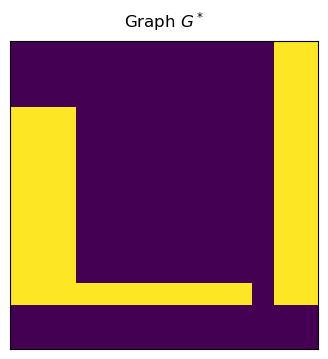

In [252]:
import matplotlib.pyplot as plt

def visualize_adj_matrix(mat, size=4.0):
    """    
    `mat`: (d, d) 
    """
    ## from DIBS library: https://github.com/larslorch/dibs/tree/master
    plt.rcParams['figure.figsize'] = [size, size]
    fig, ax = plt.subplots(1, 1)
    ax.matshow(mat, vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title(r'Graph $G^*$', pad=10)
    plt.show()
    return

bl  = bl.to_numpy()
# bl = bl[df.columns.to_list()].to_numpy()
visualize_adj_matrix(bl)


In [244]:
import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

class DagmaMLP2(DagmaMLP):

    def __init__(self, blackadj = None, **kwargs): # replace with 
        
        super().__init__(**kwargs)
        if blackadj is None:
            self.blackadj = torch.zeros(self.d, self.d).detach()
        else:
            self.blackadj = blackadj.detach()

    def h_func(self, s: float = 1.0) -> torch.Tensor:
        r"""
        Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG

        Parameters
        ----------
        s : float, optional
            Controls the domain of M-matrices, by default 1.0

        Returns
        -------
        torch.Tensor
            A scalar value of the log-det acyclicity function :math:`h(\Theta)`.
        """
        
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()  # [i, j]
        h = -torch.slogdet(s * self.I - A)[1] + self.d * np.log(s) # +inf when not a DAG

        return h + ((A * self.blackadj).sum())*1e16


class DagmaLinear2(DagmaLinear):

    def predict(self, X = None):
        if X is None:
            X = self.X

        return X @ self.W_est


def adj_to_edge_tuple(x):
    edge_list = np.stack(np.nonzero(x), axis=-1).tolist()
    return(tuple(tuple(sub) for sub in edge_list))




## Linear model

In [245]:
model = DagmaLinear2(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(train, lambda1=0.02, w_threshold = .1, exclude_edges = adj_to_edge_tuple(bl)) # fit the model with L1 reg. (coeff. 0.02)


  0%|          | 0/180000.0 [00:00<?, ?it/s]

In [246]:
np.mean((train - model.predict(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.predict(torch.tensor(test)).detach().numpy())**2)

(2.3270347833998524, 2.8728392044431645)

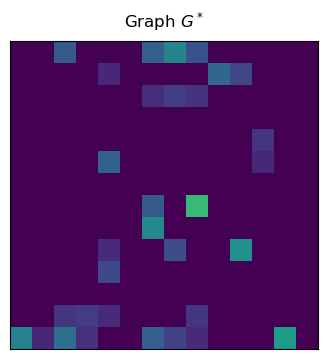

32

In [247]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()

## Non-linear model

In [255]:
eq_model = DagmaMLP2(dims=[14, 20, 1], bias=True, dtype=torch.double, blackadj = torch.tensor(bl)) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(train, lambda1=0.02, lambda2=0.005, w_threshold=.1) # fit the model with L1 reg. (coeff. 0.02) and L2 reg. (coeff. 0.005)

  0%|          | 0/230000.0 [00:00<?, ?it/s]

In [256]:
np.mean((train - model.model(torch.tensor(train)).detach().numpy())**2), np.mean((test - model.model(torch.tensor(test)).detach().numpy())**2)

(2.3226468771127315, 2.5289047964818057)

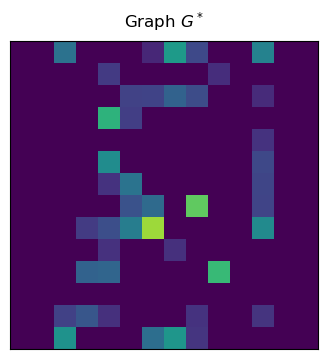

43

In [257]:
visualize_adj_matrix(W_est)
(W_est > 0).sum()

## Visualizing results

From the non-linear model.

<Axes:>

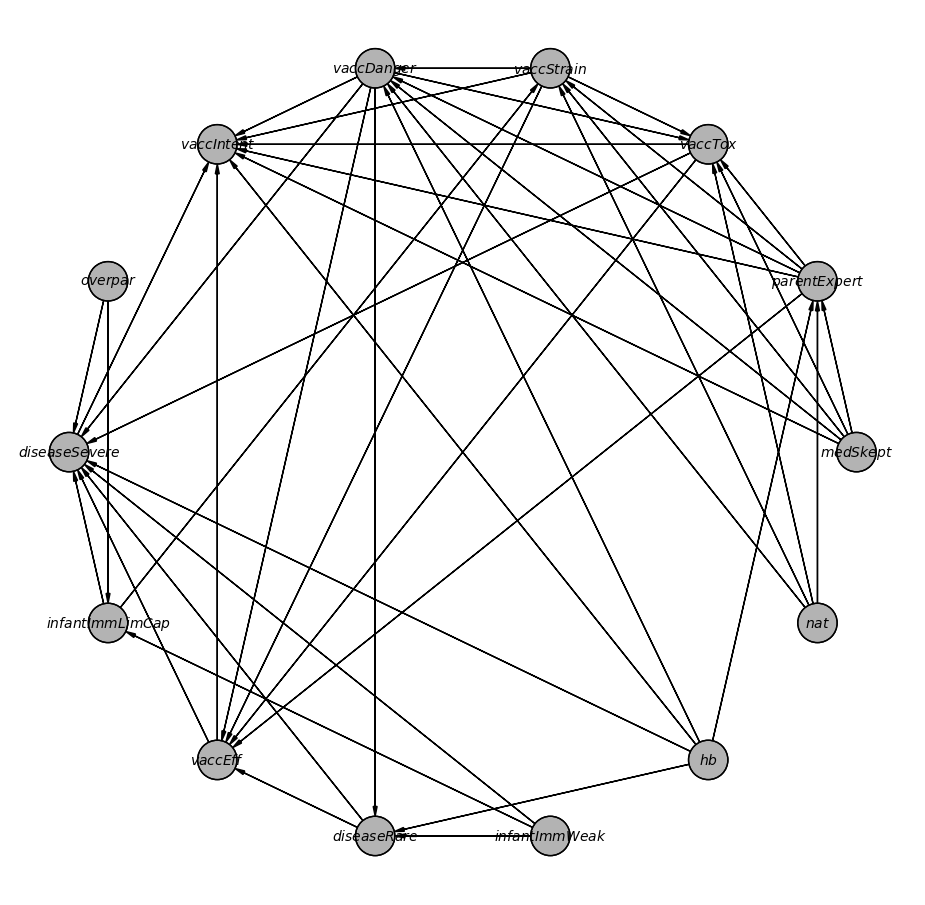

In [258]:
from pgmpy.models import BayesianNetwork

nodes = df.columns.to_list()
model_list = [ (node_order[t[0]], node_order[t[1]]) for t in list(adj_to_edge_tuple(W_est))]

modelx = BayesianNetwork(model_list)
modelx.to_daft('circular', pgm_params={'grid_unit': 10}).render()



In [280]:
# vaccTox, vaccDanger, vaccStrain, medskept, nat
from pgmpy.factors.discrete.CPD import TabularCPD

def get_cpd_vals(node, parents, fitted_model, orig_data, node_levels = 2):
    # generate values to predict for
    pred_vals = [np.min(df.min()) , np.max(df.max())]
    node_idx = orig_data.columns.get_loc(node)

    if len(parents) > 0:
        d = {p:pred_vals for p in parents}
        data = pd.MultiIndex.from_product(d.values(),names=d.keys()).to_frame().reset_index(drop=True)
    
    
        # plug into skeleton of original dataframe
        dframe = orig_data.head(len(data)).copy()
        
        
        for c in dframe.columns.to_list():
            if c in data.columns.to_list():
                dframe[c] = data[c]
        # do the predictions
        if type(model) == DagmaNonlinear:
            ps = fitted_model.model(torch.tensor(dframe.to_numpy())).detach()
        else:
            ps = fitted_model.predict(dframe.to_numpy())

    else:
        if type(model) == DagmaNonlinear: 
            ps = fitted_model.model(torch.tensor(orig_data.head(1).to_numpy())).detach()
        else:
            ps = fitted_model.predict(orig_data.head(1).to_numpy())
    ps = ps[:, node_idx] # pull out relevant predicted row based on index in original data frame

    return(np.stack([expit(ps), 1 - expit(ps)]))


def make_cpd(dag, fitted_model, node_name, orig_data, node_levels = 2):
    parents = dag.get_parents(node_name)
    ecard = [node_levels]*len(parents)
    vals = get_cpd_vals(node_name, parents, fitted_model, orig_data, node_levels)
    cpd = TabularCPD(node_name, node_levels, vals, evidence = parents, evidence_card = ecard)
    return(cpd)


def build_bn_cpds(dag, fitted_model, orig_data, node_levels = 2):
    cpdlist = [make_cpd(dag, fitted_model, n, orig_data) for n in dag.nodes()]
    return(cpdlist)
        
    
modelx.add_cpds(*build_bn_cpds(modelx, model, df))

## Inference

In [301]:
from pgmpy.inference import BeliefPropagation, VariableElimination
belief_propagation = BeliefPropagation(modelx)
q = belief_propagation.query(variables=['vaccIntent', 'vaccEff'], evidence={'vaccTox': 0}, joint=True)
print(q)

+---------------+------------+---------------------------+
| vaccIntent    | vaccEff    |   phi(vaccIntent,vaccEff) |
+===============+============+===========================+
| vaccIntent(0) | vaccEff(0) |                    0.2499 |
+---------------+------------+---------------------------+
| vaccIntent(0) | vaccEff(1) |                    0.2246 |
+---------------+------------+---------------------------+
| vaccIntent(1) | vaccEff(0) |                    0.3990 |
+---------------+------------+---------------------------+
| vaccIntent(1) | vaccEff(1) |                    0.1265 |
+---------------+------------+---------------------------+


In [372]:
def make_ER_probs(x):
    vec = np.array([.5*x, .5])
    vec = vec/vec.sum()
    return([[v] for v in vec])

def make_logER_probs(x):
    return(make_ER_probs(np.exp(x)))

virt = TabularCPD("nat", variable_card = 2, values = make_ER_probs(np.exp(-.69)))
q = belief_propagation.query(variables=['nat'], virtual_evidence=[virt], joint=True)
print(q)

+--------+------------+
| nat    |   phi(nat) |
+========+============+
| nat(0) |     0.2679 |
+--------+------------+
| nat(1) |     0.7321 |
+--------+------------+


In [342]:
modelx.get_cpds('nat').values

array([0.4218354, 0.5781646])

In [376]:
make_logER_probs(-.69)

[[0.33403307324817977], [0.6659669267518202]]